# Decision Tree Classifier from Scratch
***
## Table of Contents
1. [Introduction](#1-introduction)
    - [Structure](#structure)
    - [Construction](#construction)
    - [Advantages](#advantages)
    - [Limitation](#limitation)
2. [Loading Data](#2-loading-data)
3. [Train Test Split](#3-train-test-split)
4. [Gini Impurity and Entropy Metrics](#4-gini-impurity-and-entropy-metrics)
    - [Gini Impurity](#gini-impurity)
    - [Entropy](#entropy)
5. [Information Gain](#5-information-gain)
6. [Identifying the Best Split](#6-identifying-the-best-split)
7. [Building the Decision Tree](#7-building-the-decision-tree)
8. [Traversing the Tree for Prediction](#8-traversing-the-tree-for-prediction)
9. [Evaluation Metrics](#9-evaluation-metrics)
    - [Binary Confusion Matrix](#binary-confusion-matrix)
    - [Multi-Class Confusion Matrix](#multi-class-confusion-matrix)
    - [Accuracy](#accuracy)
    - [Precision](#precision)
    - [Recall](#recall)
    - [F1-Score](#f1-score)
10. [Predictions](#10-predictions)
11. [Model Evaluation](#11-model-evaluation)
12. [Model Encapsulation](#12-model-encapsulation)
13. [Comparison with Scikit-Learn](#13-comparison-with-scikit-learn)
***

In [1]:
from sklearn.datasets import load_breast_cancer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict
from numpy.typing import NDArray

## 1. Introduction
Decision trees and regression trees are collectively referred to as **CART**, which stands for **Classification and Regression Trees**.

- **Decision Trees** are used for classification tasks, where the target variable is *categorical*.

- **Regression Trees** are used for regression tasks, where the target variable is *continuous*.

CART is a popular algorithm that can handle both types of tasks by optimising for different criteria:

- For classification, CART minimises classification error, Gini impurity, or entropy.

- For regression, CART minimises the variance, mean squared error (MSE) or mean absolute error (MAE).

Both types of trees follow the same core idea of splitting the data based on conditions to create homogeneous subsets, but their objectives differ depending on the problem type.
In this notebook, we will build a predictive model using Decision Trees on the breast cancer dataset from the scikit-learn library.

### Structure

- **Nodes**: Represent features or decisions.

- **Edges**: Represent conditions or thresholds.

- **Leaves**: Represent outcomes or class labels (in classification) or predicted values (in regression).

### Construction

- Begins with the root node (the entire dataset).

- Splits the data based on feature thresholds that maximise the information gain (derived from Gini impurity, entropy, MSE or variance reduction).

- Recursively continues until a stopping condition is met (e.g., maximum depth, minimum samples per leaf, or pure nodes).

### Advantages

- Intuitive and easy to interpret.

- Handles both numerical and categorical data.

- Non-parametric and robust to outliers.

### Limitations

- Prone to overfitting, especially with deep trees.

- Sensitive to slight changes in the data (high variance).

## 2. Loading Data

In [2]:
# Load the dataset
data = load_breast_cancer()
feature_names = data.feature_names.tolist()
class_names = data.target_names.tolist()
X, y = data.data, data.target
df = pd.DataFrame(X, columns=feature_names)
df['diagnosis'] = y
X, y = df.drop('diagnosis', axis=1), df['diagnosis']

# Check the shape of the data
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Features: \n{feature_names}")

Features shape: (569, 30)
Target shape: (569,)
Features: 
['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension']


In [3]:
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [4]:
y.value_counts()

diagnosis
1    357
0    212
Name: count, dtype: int64

In [5]:
print(class_names)

['malignant', 'benign']


In this dataset, the features represent the characteristics of breast cancer (e.g., radius, texture, etc.), while the target is a boolean value indicating whether the tumour is malignant (0) or benign (1).

## 3. Train Test Split
Train test split is a fundamental model validation technique in machine learning. It divides a dataset into two separate portions: a **training set** used to train a model, and a **testing set** used to evaluate how well the model can perform on unseen data. 

The typical split ratio is 80% for training and 20% for testing, though this can vary (70/30 or 90/10 are also common). The key principle is that the test set must remain completely separated during model training process, and should never be used to make decisions about the model or tune parameters. 

The split is usually done randomly to ensure both sets are representative of the overall dataset, and many libraries (such as scikit-learn) provide build-in functions that handle this process automatically while maintaining proper randomisation.


In [6]:
def train_test_split(X: pd.DataFrame, y: pd.Series, test_size: float = 0.2,
                     random_state: int = None) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    """
    Split arrays or matrices into random train and test subsets.

    Args:
        X (pd.DataFrame): Input features, a 2D array with rows (samples) and columns (features).
        y (pd.Series): Target values/labels, a 1D array with rows (samples).
        test_size (float): Proportion of the dataset to include in the test split. Must be between 0.0 and 1.0. default = 0.2
        random_state (int): Seed for the random number generator to ensure reproducible results. default = None

    Returns:
        tuple[NDArray, NDArray, NDArray, NDArray]:
        A tuple containing:
            - X_train (pd.DataFrame): Training set features.
            - X_test (pd.DataFrame): Testing set features.
            - y_train (pd.Series): Training set target values.
            - y_test (pd.Series): Testing set target values.
    """
    # Set a random seed if it exists
    if random_state:
        np.random.seed(random_state)

    # Create a list of numbers from 0 to len(X)
    indices = np.arange(len(X))

    # Shuffle the indices
    np.random.shuffle(indices)

    # Define the size of our test data from len(X)
    test_size = int(test_size * len(X))

    # Generate indices for test and train data
    test_indices: NDArray[np.int64] = indices[:test_size]
    train_indices: NDArray[np.int64] = indices[test_size:]

    # Return: X_train, X_test, y_train, y_test
    return X.iloc[train_indices], X.iloc[test_indices], y.iloc[train_indices], y.iloc[test_indices]

## 4. Gini Impurity and Entropy Metrics
### Gini Impurity
Gini impurity is a measure of the likelihood that a randomly chosen sample from a dataset will be incorrectly classified. It quantifies how impure a node is, with values ranging from $0$ (minimum impurity) to $0.5$ (maximum impurity) for binary classification. For multi-class problems, however, the maximum impurity occurs when all classes are equally probable, and the value depends on the number of classes. The formula for Gini impurity is:

\begin{align*}
G = 1 - \sum_{i=1}^{k} p_{i}^{2}
\end{align*}

where:
- $k$: Number of classes.
- $p_{i}$: Proportion of samples belonging to class $i$ in the node.

In [7]:
def gini(y: pd.Series) -> float:
    proportions = np.bincount(y) / len(y)
    return 1 - np.sum(proportions**2)

### Entropy
Entropy measures the amount of uncertainty or randomness in the data. It is based on information theory and represents the expected amount of information required to classify a sample. For binary classification ranges from $0$ (minimum entropy) to $1$ (maximum entropy). For $k$ classes, the range is from $0$ to $log_{2}(k)$. The formula for entropy is:


\begin{align*}
H = - \sum_{i=1}^{k} p_{i} log_{2}(p_{i})
\end{align*}

where:
- $k$: Number of classes.
- $p_{i}$: Proportion of samples belonging to class $i$ in the node.

Gini tends to split nodes based on the most frequent classes, while entropy provides a more nuanced measure especially in cases with many classes or highly imbalanced distributions. Both metrics provide similar results, but Gini is often preferred for computational efficiency.

In [8]:
def entropy(y: pd.Series) -> float:
    proportions = np.bincount(y) / len(y)
    proportions = proportions[proportions > 0]  # Avoid log(0)
    return -np.sum(proportions * np.log2(proportions))

In [9]:
print(y.value_counts())

diagnosis
1    357
0    212
Name: count, dtype: int64


In [10]:
print(f"Gini Impurity: {gini(y):.5f}")
print(f"Entropy: {entropy(y):.5f}")

Gini Impurity: 0.46753
Entropy: 0.95264


## 5. Information Gain
Information Gain is a metric used to measure the effectiveness of a feature in splitting a dataset into subsets that are more pure concerning the target variable. It quantifies the reduction in entropy or Gini impurity, and a higher information gain indicates a better feature for making splits.

\begin{align*}
IG(S, A) = H(S) - \sum_{i=1}^{n} \dfrac{|S_i|}{|S|}H(S_{i})
\end{align*}

where:
- $H(S)$: Entropy (or Geni) of the original dataset $S$.
- $S_{i}$: Subset of $S$ created by splitting on feature $A$ for the $i_{th}$ value or range of the feature.
- $\dfrac{|S_i|}{|S|}$: Proportion of samples in subset $S_{i}$.
- $H(S_{i})$: Entropy (or Geni) of subset $S_{i}$.



The following `information_gain` function calculates the difference between the metric for the parent node and the weighted average of the metrics for the child nodes (left and right splits).

In [11]:
def information_gain(y: pd.Series, y_left: pd.Series, y_right: pd.Series,
                     metric: str = "gini") -> float:
    """
    Calculate the information gain of a split.

    Args:
        y (pd.Series): Labels of the parent node.
        y_left (pd.Series): Labels of the left child node after the split.
        y_right (pd.Series): Labels of the right child node after the split.
        metric (str, optional): Splitting criterion, either "gini" or "entropy". Defaults to "gini".

    Returns:
        float: Information gain resulting from the split.
    """
    if metric == "gini":
        parent_metric = gini(y)
        left_metric = gini(y_left)
        right_metric = gini(y_right)
    else:  # metric == "entropy"
        parent_metric = entropy(y)
        left_metric = entropy(y_left)
        right_metric = entropy(y_right)

    weighted_metric = (
        len(y_left) / len(y) * left_metric
        + len(y_right) / len(y) * right_metric
    )
    return parent_metric - weighted_metric

## 6. Identifying the Best Split
This function identifies the best feature and threshold to split the data using the specified metric (Gini or Entropy).

Steps are:

1. Loop through all features.

2. For each feature, iterate over all unique thresholds.

3. Split the data into left and right subsets based on the threshold (skip invalid ones).

4. Compute the Gini/Entropy for both subsets and calculate Information Gain.

5. If the newly computed `info_gain` > `best_info_gain`, then update `best_info_gain` with the new information.

In [12]:
def best_split(X: pd.DataFrame, y: pd.Series, metric: str = "gini", feature_names=None) -> Dict[str, int | str | float]:
    """
    Find the best split for a dataset.

    Args:
        X (pd.DataFrame): Input features (DataFrame of shape [n_samples, n_features]).
        y (pd.Series): Labels (Series of shape [n_samples]).
        metric (str, optional): Splitting criterion, either "gini" or "entropy". Defaults to "gini".
        feature_names (List[str], optional): List of feature names. If None, indices are used. Defaults to None.

    Returns:
        dict: Dictionary containing the best split with keys:
              - 'feature_index' (int): Index of the feature used for the split.
              - 'feature_name' (str/int): Name or index of the feature.
              - 'threshold' (float64): Threshold value for the split.
    """
    if feature_names is None and hasattr(X, 'columns'):
        feature_names = X.columns.tolist()

    # Convert X if DataFrame
    if hasattr(X, 'to_numpy'):
        X = X.to_numpy()

    best_info_gain = float("-inf")
    best_split = None
    n_features = X.shape[1]

    # Iterate over all features.
    for feature in range(n_features):
        # Iterate over all unique thresholds for each feature.
        thresholds = np.unique(X[:, feature])
        for threshold in thresholds:
            # Split the data into left and right subsets based on the threshold.
            left_mask = X[:, feature] <= threshold
            right_mask = X[:, feature] > threshold

            # Skip invalid splits.
            if sum(left_mask) == 0 or sum(right_mask) == 0:
                continue

            # Compute IG.
            info_gain = information_gain(
                y, y[left_mask], y[right_mask], metric)

            # Update `best_info_gain` if `info_gain` > `best_info_gain`.
            if info_gain > best_info_gain:
                best_info_gain = info_gain
                best_split = {
                    "feature_index": feature,
                    "feature_name": feature_names[feature] if feature_names is not None else feature,
                    "threshold": float(threshold),
                }

    return best_split

In [13]:
split = best_split(X, y, metric='gini')
print('Best Split:', split)

Best Split: {'feature_index': 20, 'feature_name': 'worst radius', 'threshold': 16.77}


## 7. Building the Decision Tree
This function resursively creates the tree structure as a nested dictionary with conditions (`feature` and `threshold`) and leaf nodes.

In [14]:
def build_tree(X: pd.DataFrame, y: pd.Series, max_depth: int = None,
               depth: int = 0, metric: str = "gini", feature_names: List[str | int] = None) -> Dict[
        str, str | int | float | np.float64 | Dict]:
    """
    Build a decision tree using recursive splitting.

    Args:
        X (pd.DataFrame): Input features (DataFrame of shape [n_samples, n_features]).
        y (pd.Series): Labels (Series of shape [n_samples]).
        max_depth (int, optional): Maximum depth of the tree. Defaults to None (unlimited depth).
        depth (int, optional): Current depth of the tree. Used internally for recursion. Defaults to 0.
        metric (str, optional): Splitting criterion, either "gini" or "entropy". Defaults to "gini".
        feature_names (List[str|int], optional): List of feature names. If None, indices are used. Defaults to None.

    Returns:
        Dict: Nested dictionary representing the tree structure.
              Nodes contain keys: 'type', 'feature', 'threshold', 'left', 'right'.
              Leaf nodes contain keys: 'type', 'value'.
    """

    # Convert DataFrames to NumPy arrays
    if hasattr(X, 'to_numpy'):
        X = X.to_numpy()
    if hasattr(y, 'to_numpy'):
        y = y.to_numpy().flatten()  # Ensure 1D array

    # Stop the recursion if all labels are identical or the maximum depth is reached.
    if len(set(y)) == 1 or (max_depth is not None and depth == max_depth):
        return {"type": "leaf", "value": int(np.argmax(np.bincount(y)))}

    # Find the best split.
    split = best_split(X, y, metric, feature_names)
    if not split:
        return {"type": "leaf", "value": int(np.argmax(np.bincount(y)))}

    # Split the data into left and right subsets.
    # Use feature_index for calculations.
    left_mask = X[:, split["feature_index"]] <= split["threshold"]
    right_mask = X[:, split["feature_index"]] > split["threshold"]

    # Recursively build the left and right subtrees.
    left_tree = build_tree(X[left_mask], y[left_mask],
                           max_depth, depth + 1, metric, feature_names)
    right_tree = build_tree(X[right_mask], y[right_mask],
                            max_depth, depth + 1, metric, feature_names)

    # Return the tree structure as a nested dictionary.
    return {
        "type": "node",
        "feature": split["feature_name"],
        "threshold": split["threshold"],
        "left": left_tree,
        "right": right_tree,
    }

## 8. Traversing the Tree for Prediction
This function traverses the tree to make predictions by following the tree from the root to a leaf node.

In [15]:
def traverse_tree(x: pd.DataFrame, tree: Dict[str, str | int | float | np.float64 | Dict],
                  feature_names: List[str | int] = None) -> int:
    """
    Traverse a decision tree to make a prediction for a single sample.

    Args:
        x (pd.DataFrame): Single sample.
        tree (Dict[str, str | int | float | np.float64 | Dict]): Decision tree structure.
        feature_names (List[str|int], optional): List of feature names. Needed for name-to-index mapping. Defaults to None.

    Returns:
        int: Predicted label.
    """
    if tree["type"] == "leaf":
        return tree["value"]

    # Resolve feature index if feature_names is provided
    feature_index = feature_names.index(
        tree["feature"]) if feature_names is not None else tree["feature"]

    if x[feature_index] <= tree["threshold"]:
        return traverse_tree(x, tree["left"], feature_names)
    else:
        return traverse_tree(x, tree["right"], feature_names)

## 9. Evaluation Metrics
### Binary Confusion Matrix
In a confusion matrix, the terms True Positive (TP), True Negative (TN), False Positive (FP), and False Negative (FN) describe the classification performance for binary classification. 

|                     | Predicted Negative  | Predicted Positive  |
| ------------------- | ------------------- | ------------------- |
| **Actual Negative** | True Negative (TN)  | False Positive (FP) |
| **Actual Positive** | False Negative (FN) | True Positive (TP)  |


1. True Positive (TP): The number of instances correctly predicted as positive (e.g., a disease correctly identified).

2. True Negative (TN): The number of instances correctly predicted as negative (e.g., no disease correctly identified).

3. False Positive (FP): The number of instances incorrectly predicted as positive (e.g., predicting disease when there isn't any).

4. False Negative (FN): The number of instances incorrectly predicted as negative (e.g., missing a disease when it exists).

### Multi-Class Confusion Matrix
For multi-class classification, the concepts can be extended by treating one class as the "positive" class and all others as "negative" classes in a one-vs-all approach. Rows represent the actual classes (true labels), and columns represent the predicted classes. For a class $C$,
1. True Positive (TP): The count in the diagonal cell corresponding to class $C$ ($\text{matrix} [C][C]$).
2. False Positive (FP): The sum of the column for class $C$, excluding the diagonal ($\sum(\text{matrix} [:, C]) - \text{matrix} [C][C]$).
3. False Negative (FN): The sum of the row for class $C$, excluding the diagonal ($\sum(\text{matrix} [C, :]) - \text{matrix} [C][C]$).
4. True Negative (TN): All other cells not in the row or column for class $C$ ($\text{total} - (FP + FN + TP)$).

|                  | Predicted Class 0 | Predicted Class 1 | Predicted Class 2 |
| ---------------- | ----------------- | ----------------- | ----------------- |
| **True Class 0** | 5                 | 2                 | 0                 |
| **True Class 1** | 1                 | 6                 | 1                 |
| **True Class 2** | 0                 | 2                 | 7                 |


For Class 0:
- TP = 5 (diagonal element for Class 0)
- FP = 1 (sum of column 0 minus TP: 1 + 0)
- FN = 2 (sum of row 0 minus TP: 2 + 0)
- TN = 6 + 1 + 2 + 7 = 16 (all other cells not in row 0 or column 0)

For Class 1:
- TP = 6 (diagonal element for Class 1)
- FP = 4 (sum of column 1 minus TP: 2 + 2)
- FN = 2 (sum of row 1 minus TP: 1 + 1)
- TN = 5 + 0 + 0 + 7 = 12 (all other cells not in row 1 or column 1)

In [16]:
def confusion_matrix(y_true: NDArray[np.int64], y_pred: NDArray[np.int64],
                     class_names: List[str] = None) -> Tuple[NDArray[np.int64], List[str]]:
    """
    Calculate the confusion matrix.

    Args:
        y_true (NDArray[np.int64]): True labels.
        y_pred (NDArray[np.int64]): Predicted labels.
        class_names (List[str], optional): List of class names. Defaults to None.

    Returns:
        Tuple: 
        - NDArray[np.int64]: Confusion matrix.
        - List[str]: List of class names.
    """
    # Encode labels as integers
    unique_classes = np.unique(y_true)
    if class_names is None:
        class_names = [str(cls) for cls in unique_classes]
    class_to_index = {cls: i for i, cls in enumerate(unique_classes)}

    n_classes = len(unique_classes)
    matrix = np.zeros((n_classes, n_classes), dtype=int)

    for true, pred in zip(y_true, y_pred):
        true_idx = class_to_index[true]
        pred_idx = class_to_index[pred]
        matrix[true_idx][pred_idx] += 1

    return matrix, class_names

### Accuracy
Accuracy is the most common evaluation metric for classification problems, representing the percentage of correct predictions out of total predictions. It provides a simple measure of how often the classifier makes correct predictions across all classes.

\begin{align*}
\text{Accuracy} = \dfrac{\text{True Positives (TP)} + \text{True Negatives (TN)}}{\text{Total Samples}}
\end{align*}

In [17]:
def accuracy(y_true: NDArray[np.int64],
             y_pred: NDArray[np.int64]) -> float:
    """
    Calculate the accuracy of predictions by comparing true and predicted labels.

    Args:
        y_true (NDArray[np.int64]): Ground truth target values. Contains the actual class labels for each sample.
        y_pred (NDArray[np.int64]): Estimated target as returned by a classifier. Contains the predicted class labels for each sample.
    Returns:
        float: Classification accuracy as a percentage (0.0 to 100.0).
    """
    return np.mean(y_true == y_pred)

### Precision
Precision measures the proportion of true positive predictions out of all positive predictions made by the classifier.

\begin{align*}
\text{Precision} = \dfrac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Positives (FP)}}
\end{align*}

In [18]:
def precision(y_true: NDArray[np.int64], y_pred: NDArray[np.int64]) -> NDArray[np.float64]:
    """
    Calculate precision for each class.

    Args:
        y_true (NDArray[np.int64]): True labels.
        y_pred (NDArray[np.int64]): Predicted labels.

    Returns:
        NDArray[np.float64]: Precision values for each class.
    """
    cm, _ = confusion_matrix(y_true, y_pred)
    return np.diag(cm) / (np.sum(cm, axis=0) + 1e-7)

### Recall
Recall measures the proportion of true positive predications out of all actual positive cases.

\begin{align*}
\text{Recall} = \dfrac{\text{True Positives (TP)} }{\text{True Positives (TP)} + \text{False Negatives (FN)}}
\end{align*}

In [19]:
def recall(y_true: NDArray[np.int64], y_pred: NDArray[np.int64]) -> NDArray[np.float64]:
    """
    Calculate recall for each class.

    Args:
        y_true (NDArray[np.int64]): True labels.
        y_pred (NDArray[np.int64]): Predicted labels.

    Returns:
        NDArray[np.float64]: Recall values for each class.
    """
    cm, _ = confusion_matrix(y_true, y_pred)
    return np.diag(cm) / (np.sum(cm, axis=1) + 1e-7)

### F1-Score
The F1-Score is the harmonic mean of precision and recall.

\begin{align*}
\text{F1-Score} = 2 \times \dfrac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
\end{align*}

In [20]:
def f1_score(y_true: NDArray[np.int64], y_pred: NDArray[np.int64]) -> NDArray[np.float64]:
    """
    Calculate F1-score for each class.

    Args:
        y_true (NDArray[np.int64]): True labels.
        y_pred (NDArray[np.int64]): Predicted labels.

    Returns:
        NDArray[np.float64]: F1-scores for each class.
    """
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2 * (prec * rec) / (prec + rec + 1e-7)

In [21]:
def evaluate(y_true: NDArray[np.int64], y_pred: NDArray[np.int64], class_names: List[str] = None) -> None:
    """
    Print evaluation metrics including accuracy, precision, recall, and F1-score for each class.

    Args:
        y_true (NDArray[np.int64]): True labels.
        y_pred (NDArray[np.int64]): Predicted labels.
        class_names (List[str], optional): List of class names. Defaults to None.
    """
    cm, class_names = confusion_matrix(y_true, y_pred, class_names)
    acc = accuracy(y_true, y_pred)
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    # print("Class\tPrecision\tRecall\tF1-Score")
    # for i, class_name in enumerate(class_names):
    #     print(f"{class_name}\t{prec[i]:.4f}\t\t{rec[i]:.4f}\t{f1[i]:.4f}")
    return acc, np.mean(prec), np.mean(rec), np.mean(f1), cm

## 10. Predictions
This function predicts labels for all samples in the dataset.

In [22]:
def predict(X: pd.DataFrame, tree: Dict[str, str | int | float | np.float64 | Dict],
            feature_names: List[str | int] = None) -> int | NDArray[np.int64]:
    """
    Predict labels for the given dataset using a decision tree classifier.

    Args:
        X (pd.DataFrame): Input features.
        tree (Dict[str, str | int | float | np.float64 | Dict]): Decision tree structure.
        feature_names (List[str|int], optional): List of feature names. Needed for name-to-index mapping. Defaults to None.

    Returns:
        int | NDArray[np.int64]: Predicted labels (1D array for multiple samples or a single label for one sample).
    """
    # Convert DataFrames to NumPy arrays
    if hasattr(X, 'to_numpy'):
        X = X.to_numpy()

    if len(X.shape) == 1:  # If a single sample is provided
        return traverse_tree(X, tree, feature_names)
    return np.array([traverse_tree(x, tree, feature_names) for x in X])

In [23]:
# Load the dataset
import pprint

# Build the tree using Gini impurity
tree_gini = build_tree(X, y, max_depth=3, metric="gini",
                       feature_names=feature_names)

# Display the tree
pprint.pprint(tree_gini)

{'feature': 'worst radius',
 'left': {'feature': 'worst concave points',
          'left': {'feature': 'radius error',
                   'left': {'type': 'leaf', 'value': 1},
                   'right': {'type': 'leaf', 'value': 0},
                   'threshold': 0.8811,
                   'type': 'node'},
          'right': {'feature': 'worst texture',
                    'left': {'type': 'leaf', 'value': 1},
                    'right': {'type': 'leaf', 'value': 0},
                    'threshold': 25.5,
                    'type': 'node'},
          'threshold': 0.1357,
          'type': 'node'},
 'right': {'feature': 'mean texture',
           'left': {'feature': 'mean concave points',
                    'left': {'type': 'leaf', 'value': 1},
                    'right': {'type': 'leaf', 'value': 0},
                    'threshold': 0.06211,
                    'type': 'node'},
           'right': {'feature': 'worst smoothness',
                     'left': {'type': 'leaf', 'valu

## 11. Model Evaluation

In [24]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

# Build the tree on training data
tree_gini = build_tree(X_train, y_train, max_depth=3,
                       metric="gini", feature_names=feature_names)

# Predict on the test set
y_pred = predict(X_test, tree_gini, feature_names=feature_names)

# Predict a single sample
single_sample = X_test.iloc[0]
single_prediction = predict(
    single_sample, tree_gini, feature_names=feature_names)
print("Predicted label for single sample:", single_prediction)
print("Actual label for single sample:", y_test.iloc[0])

acc, prec, rec, f1, cm = evaluate(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Confusion Matrix:\n{cm}")
print('--------------------')

Predicted label for single sample: 1
Actual label for single sample: 1
Accuracy: 0.9647
Precision: 0.9597
Recall: 0.9654
F1-Score: 0.9624
Confusion Matrix:
[[ 61   2]
 [  4 103]]
--------------------


## 12. Model Encapsulation

To encapsulate the codes above, it will be a better idea to divide them into two different classes:
1. `CustomDecisionTreeClassifier` containing the core logic for building, traversing and predicting using the decision tree.
2. `Node` representing a single node in the decision tree, either internal node or leaf node.

In [25]:
class Node:
    """
    A class representing a node in the decision tree.

    Attributes:
        type (str): Type of the node ("leaf" or "node").
        value (int or None): Predicted label for leaf nodes. None for internal nodes.
        feature (int or None): Index of the feature for internal nodes. None for leaf nodes.
        threshold (float or None): Threshold value for internal nodes. None for leaf nodes.
        left (Node or None): Left child node. None for leaf nodes.
        right (Node or None): Right child node. None for leaf nodes.
    """

    def __init__(self, type: str, value: float = None,
                 feature: int = None, threshold: float = None, left: 'Node' = None, right: 'Node' = None):
        """
        Initialise a Node instance.

        Args:
        type (str): Type of the node ("leaf" or "node").
        value (int or None): Predicted label for leaf nodes. None for internal nodes.
        feature (int or None): Index of the feature for internal nodes. None for leaf nodes.
        threshold (float or None): Threshold value for internal nodes. None for leaf nodes.
        left (Node or None): Left child node. None for leaf nodes.
        right (Node or None): Right child node. None for leaf nodes.
        """
        self.type = type  # "leaf" or "node"
        self.value = value  # For leaf nodes
        self.feature = feature  # For internal nodes
        self.threshold = threshold  # For internal nodes
        self.left = left  # Left child
        self.right = right  # Right child

In [ ]:
class CustomDecisionTreeClassifier:
    """
    A class representing a decision tree classifier.

    Args:
        max_depth (int or None): Maximum depth of the tree. None for unlimited depth.
        metric (str): Splitting criterion, either 'gini' or 'entropy'.

    Attributes:
        max_depth (int or None): Maximum depth of the tree.
        metric (str): Splitting criterion.
        root (Node or None): Root node of the decision tree, initialised as None.
        feature_names (list[str] or None): Names of the features, set during fitting.
        class_names (List[str] or None): Names of the classes, set during fitting.
    """

    def __init__(self, max_depth: int = None, metric: str = 'gini'):
        self.max_depth = max_depth
        self.metric = metric
        self.root = None
        self.feature_names = None
        self.class_names = None

    def gini(self, y: pd.Series) -> float:
        """
        Calculate the Gini impurity.

        Args:
            y (pd.Series): Series of labels.

        Returns:
            float: Gini impurity.
        """
        if len(y) == 0:
            return 0
        proportions = np.bincount(y) / len(y)
        return 1 - np.sum(proportions ** 2)

    def entropy(self, y: pd.Series) -> float:
        """
        Calculate the entropy.

        Args:
            y (NDArray[np.int64]): Series of labels.

        Returns:
            float: Entropy value.
        """
        if len(y) == 0:
            return 0
        proportions = np.bincount(y) / len(y)
        proportions = proportions[proportions > 0]  # Avoid log(0)
        return -np.sum(proportions * np.log2(proportions))

    def information_gain(self, y: pd.Series, y_left: pd.Series, y_right: pd.Series) -> float:
        """
        Compute the information gain of a split.

        Args:
            y (pd.Series): Series of the parent node.
            y_left (pd.Series): Series of the left child node.
            y_right (pd.Series): Series of the right child node.

        Returns:
            float: Information gain from the split.
        """
        if self.metric == "gini":
            parent_metric = self.gini(y)
            left_metric = self.gini(y_left)
            right_metric = self.gini(y_right)
        else:  # metric == "entropy"
            parent_metric = self.entropy(y)
            left_metric = self.entropy(y_left)
            right_metric = self.entropy(y_right)

        weighted_metric: float = (
            len(y_left) / len(y) * left_metric
            + len(y_right) / len(y) * right_metric
        )
        return parent_metric - weighted_metric

    def best_split(self, X: pd.DataFrame, y: pd.Series) -> Dict[str, int | str | float]:
        """
        Find the best feature and threshold to split the dataset.

        Args:
            X (pd.DataFrame): Input features.
            y (pd.Series): Labels as int.

        Returns:
            dict: Dictionary containing the best split with keys:
              - 'feature_index' (int): Index of the feature used for the split.
              - 'feature_name' (str/int): Name or index of the feature.
              - 'threshold' (float64): Threshold value for the split.
        """
        best_info_gain = float("-inf")
        best_split: Dict = None
        n_features: int = X.shape[1]

        # Iterate over all features.
        for feature in range(n_features):
            # Iterate over all unique thresholds for each feature.
            thresholds: NDArray[np.float64] = np.unique(X[:, feature])
            for threshold in thresholds:
                # Split the data into left and right subsets based on the threshold.
                left_mask: NDArray[np.bool] = X[:, feature] <= threshold
                right_mask: NDArray[np.bool] = X[:, feature] > threshold

                # Skip invalid splits.
                if sum(left_mask) == 0 or sum(right_mask) == 0:
                    continue

                # Compute IG.
                info_gain: float = self.information_gain(
                    y, y[left_mask], y[right_mask])

                # Update `best_info_gain` if `info_gain` > `best_info_gain`.
                if info_gain > best_info_gain:
                    best_info_gain = info_gain
                    best_split = {
                        "feature_index": feature,
                        "threshold": threshold,
                    }

        return best_split

    def build_tree(self, X: pd.DataFrame, y: pd.Series, depth: int = 0) -> Node:
        """
        Build the decision tree recursively.

        Args:
            X (pd.DataFrame): Input features.
            y (pd.Series): Labels.
            depth (int): Current depth of the tree.

        Returns:
            Node: Root node of the decision tree.
        """

        # Convert DataFrames to NumPy arrays
        if hasattr(X, 'to_numpy'):
            X = X.to_numpy()
        if hasattr(y, 'to_numpy'):
            y = y.to_numpy().flatten()  # Ensure 1D array

        # Stop recursion if all labels are identical or max depth is reached
        if len(set(y)) == 1 or (self.max_depth is not None and depth == self.max_depth):
            return Node(type="leaf", value=np.argmax(np.bincount(y)))

        # Find the best split
        split: Dict = self.best_split(X, y)
        if not split:
            return Node(type="leaf", value=np.argmax(np.bincount(y)))

        # Split the data
        left_mask: NDArray[np.bool] = X[:,
                                        split["feature_index"]] <= split["threshold"]
        right_mask: NDArray[np.bool] = X[:,
                                         split["feature_index"]] > split["threshold"]

        # Recursively build the left and right subtrees
        left_tree: Node = self.build_tree(
            X[left_mask], y[left_mask], depth + 1)
        right_tree: Node = self.build_tree(
            X[right_mask], y[right_mask], depth + 1)

        # Store the feature index directly for easier traversal
        feature_index: int = split["feature_index"]

        return Node(type="node", feature=feature_index, threshold=split["threshold"], left=left_tree, right=right_tree)

    def fit(self, X: pd.DataFrame, y: pd.Series,
            class_names: NDArray[np.str_], feature_names: NDArray[np.str_] = None) -> None:
        """
        Fit the decision tree model to the given data.

        Args:
            X (pd.DataFrame): Input features.
            y (pd.Series): Labels.
            class_names (NDArray[np.str_]): Names of the labels.
            feature_names (NDArray[np.str_], optional): Names of the features. Defaults to None.
        """
        self.feature_names = feature_names
        self.class_names = class_names
        self.root = self.build_tree(X, y)

    def traverse_tree(self, x: pd.DataFrame, node: Node) -> int:
        """
        Traverse the decision tree to make a prediction for a single sample.

        Args:
            x (pd.DataFrame): Single sample.
            node (Node): Current node.

        Returns:
            int: Predicted label.
        """
        if node.type == "leaf":
            return node.value

        # node.feature = feature index
        feature_index: int = node.feature
        if x[feature_index] <= node.threshold:
            return self.traverse_tree(x, node.left)
        else:
            return self.traverse_tree(x, node.right)

    def predict(self, X: pd.DataFrame) -> int | NDArray[np.int64]:
        """
        Predict labels for the given dataset.

        Args:
            X (pd.DataFrame): Input features.

        Returns:
            int or NDArray[np.int64]: Predicted label(s).
        """
        # Convert DataFrames to NumPy arrays
        if hasattr(X, 'to_numpy'):
            X = X.to_numpy()

        if len(X.shape) == 1:
            return self.traverse_tree(X, self.root)
        return np.array([self.traverse_tree(x, self.root) for x in X])

    def print_tree(self, node: Node = None, depth: int = 0, prefix: str = "Root: ") -> None:
        """
        Print the tree structure in a readable format.

        Args:
            node (Node, optional): Current node. Defaults to the root node.
            depth (int, optional): Current depth. Defaults to 0.
            prefix (str, optional): Prefix for the current node. Defaults to "Root: ".
        """
        if node is None:
            node = self.root

        if node.type == "leaf":
            print("  " * depth + prefix +
                  f"Predict -> {self.class_names[node.value]}")
        else:
            feature_name = self.feature_names[
                node.feature] if self.feature_names is not None else f"Feature_{node.feature}"
            print("  " * depth + prefix +
                  f"{feature_name} <= {node.threshold:.4f}")
            if node.left:
                self.print_tree(node.left, depth + 1, "├─ True: ")
            if node.right:
                self.print_tree(node.right, depth + 1, "└─ False: ")

In [27]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

# Train the decision tree
tree = CustomDecisionTreeClassifier(max_depth=3, metric="gini")
tree.fit(X_train, y_train, feature_names=feature_names, class_names=class_names)

# Predict and evaluate
y_pred = tree.predict(X_test)

# Single prediction
sample = X_test.iloc[0]
single_prediction = tree.predict(sample)
print(
    f"Predicted: {class_names[single_prediction]}, Actual: {class_names[y_test.iloc[0]]}")

acc_custom, prec_custom, rec_custom, f1_custom, cm_custom = evaluate(
    y_test, y_pred)
print(f"Accuracy (Custom): {acc_custom:.4f}")
print(f"Precision: (Custom) {prec_custom:.4f}")
print(f"Recall (Custom): {rec_custom:.4f}")
print(f"F1-Score (Custom): {f1_custom:.4f}")
print(f"Confusion Matrix (Custom):\n{cm_custom}")
print('--------------------')

# Print the tree structure
print("\nDecision Tree Structure:")
tree.print_tree()

Predicted: benign, Actual: benign
Accuracy (Custom): 0.9647
Precision: (Custom) 0.9597
Recall (Custom): 0.9654
F1-Score (Custom): 0.9624
Confusion Matrix (Custom):
[[ 61   2]
 [  4 103]]
--------------------

Decision Tree Structure:
Root: mean concave points <= 0.0507
  ├─ True: worst radius <= 16.7700
    ├─ True: radius error <= 0.6061
      ├─ True: Predict -> benign
      └─ False: Predict -> malignant
    └─ False: mean texture <= 15.7000
      ├─ True: Predict -> benign
      └─ False: Predict -> malignant
  └─ False: worst texture <= 19.4900
    ├─ True: mean concave points <= 0.0853
      ├─ True: Predict -> benign
      └─ False: Predict -> malignant
    └─ False: worst area <= 709.0000
      ├─ True: Predict -> benign
      └─ False: Predict -> malignant


## 13. Comparison with Scikit-Learn

In [28]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

Accuracy: (SK) 0.9647
Accuracy (Custom): 0.9647
--------------------
Precision: (SK) 0.9648
Precision: (Custom) 0.9597
--------------------
Recall (SK): 0.9647
Recall (Custom): 0.9654
--------------------
F1-Score (SK): 0.9646
F1-Score (Custom): 0.9624
--------------------
Confusion Matrix (SK):
[[ 59   4]
 [  2 105]]
Confusion Matrix (Custom):
[[ 61   2]
 [  4 103]]


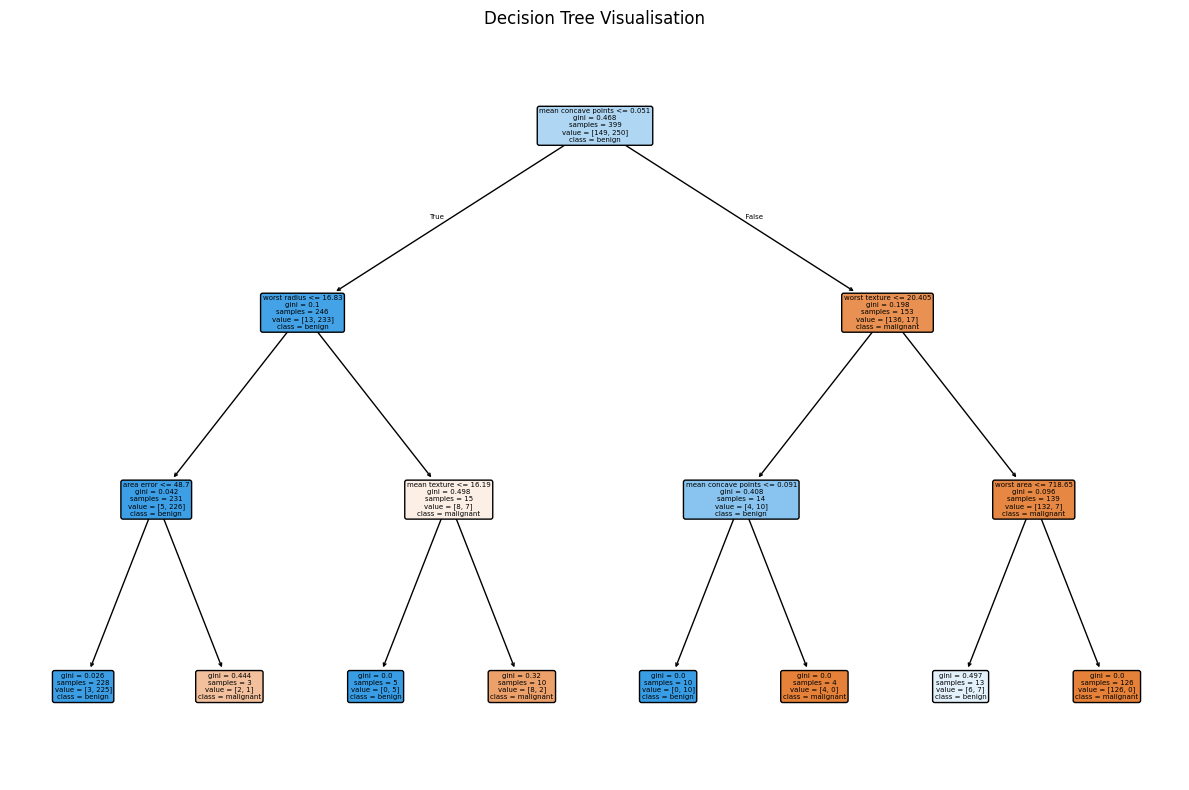

In [29]:
# Train a Decision Tree Classifier
clf = DecisionTreeClassifier(max_depth=3, criterion="gini", random_state=42)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
acc_sk = accuracy_score(y_test, y_pred)
prec_sk = precision_score(y_test, y_pred, average='weighted')
rec_sk = recall_score(y_test, y_pred, average='weighted')
f1_sk = f1_score(y_test, y_pred, average='weighted')
cm_sk = confusion_matrix(y_test, y_pred)

print(f"Accuracy: (SK) {acc_sk:.4f}")
print(f"Accuracy (Custom): {acc_custom:.4f}")
print('--------------------')
print(f"Precision: (SK) {prec_sk:.4f}")
print(f"Precision: (Custom) {prec_custom:.4f}")
print('--------------------')
print(f"Recall (SK): {rec_sk:.4f}")
print(f"Recall (Custom): {rec_custom:.4f}")
print('--------------------')
print(f"F1-Score (SK): {f1_sk:.4f}")
print(f"F1-Score (Custom): {f1_custom:.4f}")
print('--------------------')
print(f"Confusion Matrix (SK):\n{cm_sk}")
print(f"Confusion Matrix (Custom):\n{cm_custom}")

# Visualise the decision tree
plt.figure(figsize=(12, 8))
plot_tree(
    clf,
    feature_names=feature_names,
    class_names=class_names,
    filled=True,
    rounded=True
)
plt.title("Decision Tree Visualisation")
plt.tight_layout()
plt.show()

The results provided by our custom model are very similar to those of the scikit-learn model!